# MNIST

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
    
import datetime
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import matplotlib.pyplot as plt

%matplotlib inline

print("Tensorflow version: ",tf.__version__)
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow version:  2.0.0
Num GPUs Available:  0


# Loading data from storage

In [ ]:
# Prepare MNIST Data
(train_data, train_label), (test_data, test_label) = datasets.mnist.load_data()
# Add new deminsion for TF2
train_data  = train_data[...,tf.newaxis] 
test_data   = test_data[...,tf.newaxis] 
train_label = train_label[...,tf.newaxis] 
test_label  = test_label[...,tf.newaxis] 

# Convert to float32
train_data,test_data = np.array(train_data,np.float32), np.array(test_data,np.float32)

print("train_data shape: ", np.shape(train_data))
print("train_label shape: ", np.shape(train_label))

print("\n")

print("test_data shape: ", np.shape(test_data))
print("test_label shape: ", np.shape(test_label))

# Get info for test data
N_EXAMPLE,HEIGHT,WIDTH,NUM_CHANNELS = np.shape(test_data)
batch_size = 128

In [ ]:
NUM_CLASSES = 10
class_names = ['zero', 'one', 'two', 'three', 'four', 'five','six', 'seven', 'eight', 'nine']

In [ ]:
def plotImages(dataset):
    i=0
    plt.figure(figsize=(15,15))
    for image,label in dataset.take(15):
        plt.subplot(1, 15, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.cm.binary)
        plt.xlabel(class_names[label.numpy()[0]])
        i = i + 1
    plt.tight_layout()
    plt.show()

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))
plotImages(train_dataset)

# Data Pipeline

## Apply Data Augmentation


In [ ]:
# Prepare MNIST Data
(train_data, train_label), (test_data, test_label) = datasets.mnist.load_data()
# Add new deminsion for TF2
train_data  = train_data[...,tf.newaxis] 
test_data   = test_data[...,tf.newaxis] 
train_label = train_label[...,tf.newaxis] 
test_label  = test_label[...,tf.newaxis] 

# Convert to float32
train_data,test_data = np.array(train_data,np.float32), np.array(test_data,np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))
################################################################################

NUM_CHANNELS = 1
def augmentation(x, y):
    x = tf.image.resize_with_crop_or_pad(
        x, HEIGHT + 8, WIDTH + 8)
    x = tf.image.random_crop(x, [HEIGHT, WIDTH, NUM_CHANNELS])
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return x, y

train_dataset = train_dataset.map(augmentation)
plotImages(train_dataset)

## Shuffling

In [ ]:
# Prepare MNIST Data
(train_data, train_label), (test_data, test_label) = datasets.mnist.load_data()
# Add new deminsion for TF2
train_data  = train_data[...,tf.newaxis] 
test_data   = test_data[...,tf.newaxis] 
train_label = train_label[...,tf.newaxis] 
test_label  = test_label[...,tf.newaxis] 

# Convert to float32
train_data,test_data = np.array(train_data,np.float32), np.array(test_data,np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))
################################################################################

NUM_CHANNELS = 1
train_dataset = (train_dataset
                 .map(augmentation)
                 .shuffle(buffer_size=50000))
print(train_data.shape, train_label.shape)
plotImages(train_dataset)

## Normalization

In [ ]:
# Prepare MNIST Data
(train_data, train_label), (test_data, test_label) = datasets.mnist.load_data()
# Add new deminsion for TF2
train_data  = train_data[...,tf.newaxis] 
test_data   = test_data[...,tf.newaxis] 
train_label = train_label[...,tf.newaxis] 
test_label  = test_label[...,tf.newaxis] 

# Convert to float32
train_data,test_data = np.array(train_data,np.float32), np.array(test_data,np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))
################################################################################

NUM_CHANNELS = 1
def normalize(x, y):
    x = tf.image.per_image_standardization(x)
    return x, y

train_dataset = (train_dataset
                 .map(augmentation)
                 .shuffle(buffer_size=50000)
                 .map(normalize))

print(train_data.shape, train_label.shape)
plotImages(train_dataset)

## Batching

In [ ]:
# Prepare MNIST Data
(train_data, train_label), (test_data, test_label) = datasets.mnist.load_data()
# Add new deminsion for TF2
train_data  = train_data[...,tf.newaxis] 
test_data   = test_data[...,tf.newaxis] 
train_label = train_label[...,tf.newaxis] 
test_label  = test_label[...,tf.newaxis] 

# Convert to float32
train_data,test_data = np.array(train_data,np.float32), np.array(test_data,np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))
################################################################################

train_dataset = (train_dataset.map(augmentation)
                 .map(normalize)
                 .shuffle(50000)
                 .batch(32))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_label)).batch(32)

print(train_dataset)
print(test_dataset)

# Training the model


In [ ]:
IMG_SIZE = (28, 28, 1)
input_img = layers.Input(shape=IMG_SIZE)

model = layers.Conv2D(32, (3, 3), padding='same')(input_img)
model = layers.Activation('relu')(model)
model = layers.Conv2D(32, (3, 3), padding='same', strides=(2, 2))(model)
model = layers.Activation('relu')(model)

model = layers.Conv2D(64, (3, 3), padding='same')(model)
model = layers.Activation('relu')(model)
model = layers.Conv2D(64, (3, 3), padding='same', strides=(2, 2))(model)
model = layers.Activation('relu')(model)

model = layers.Conv2D(64, (3, 3), padding='same')(model)
model = layers.Activation('relu')(model)
model = layers.Conv2D(64, (3, 3), padding='same')(model)
model = layers.Activation('relu')(model)

model = layers.GlobalAveragePooling2D()(model)
model = layers.Dense(32)(model)
model = layers.Activation('relu')(model)
model = layers.Dense(10)(model)
output_img = layers.Activation('softmax')(model)

model = models.Model(input_img, output_img)

model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=["accuracy"])

history = model.fit(train_dataset, epochs=10, 
                    validation_data = test_dataset)

# Visualize the model

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluate the model on the test dataset

In [ ]:
(train_data, train_label), (test_data, test_label) = datasets.mnist.load_data()

train_data = train_data[...,tf.newaxis] # this is cause of tensorflow 
test_data = test_data[...,tf.newaxis] # this is cause of tensorflow

train_label = train_label[...,tf.newaxis] # this is cause of tensorflow 
test_label = test_label[...,tf.newaxis] # this is cause of tensorflow

print(train_data.shape, train_label.shape)
################################################################################

model.evaluate(test_data, test_label)

In [ ]:
# Prepare MNIST Data
(train_data, train_label), (test_data, test_label) = datasets.mnist.load_data()
# Add new deminsion for TF2
train_data  = train_data[...,tf.newaxis] 
test_data   = test_data[...,tf.newaxis] 
train_label = train_label[...,tf.newaxis] 
test_label  = test_label[...,tf.newaxis] 

# Convert to float32
train_data,test_data = np.array(train_data,np.float32), np.array(test_data,np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))

# Memory Leak if not do this line with batch size
# Adjust Batch size accordingly, lower if memory leak
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_label)).batch(128)
############################################################################

test_accuracy = tf.keras.metrics.Accuracy()

for timages, tlabels in test_dataset:
    logits = model(timages)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, tlabels)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))
#print(prediction)

In [ ]:
# Predict 5 images from test set
n_images = 20
test_images = test_data[:n_images]
predictions = model(test_images)

# Display image and model prediction
plt.figure(figsize=(20,20))
for i in range(n_images):
    plt.subplot(n_images, 1, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(test_images[i], [28,28]), cmap='gray')
    plt.xlabel("Model Prediciton:%i" % np.argmax(predictions.numpy()[i]))
plt.tight_layout()
plt.show() 

## Save Model

In [ ]:
model.save("model.h5")
print("Saved model to disk")

## Load Model

In [13]:
from numpy import loadtxt
from tensorflow.keras.models import load_model

# load model
model = load_model('model.h5')
# summarize model.
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0     

In [14]:
# Prepare MNIST Data
(train_data, train_label), (test_data, test_label) = datasets.mnist.load_data()
# Add new deminsion for TF2
train_data  = train_data[...,tf.newaxis] 
test_data   = test_data[...,tf.newaxis] 
train_label = train_label[...,tf.newaxis] 
test_label  = test_label[...,tf.newaxis] 

# Convert to float32
train_data,test_data = np.array(train_data,np.float32), np.array(test_data,np.float32)
model.evaluate(test_data, test_label)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[8.101301587709079, 0.9607]

In [15]:
# Memory Leak if not do this line with batch size
# Adjust Batch size accordingly, lower if memory leak
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_label)).batch(128)
############################################################################

test_accuracy = tf.keras.metrics.Accuracy()

for timages, tlabels in test_dataset:
    logits = model(timages)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, tlabels)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.070%


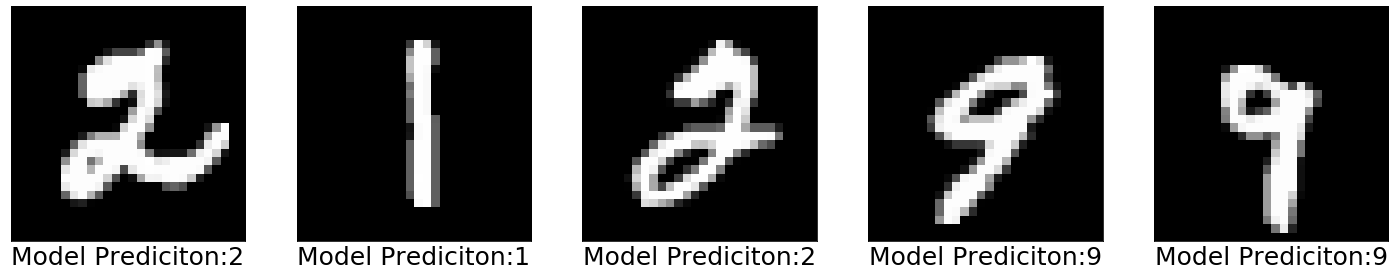

In [37]:
# Predict 5 images from test set
n_images = 5
test_images = test_data[:n_images]
predictions = model(test_images)

# Display image and model prediction
plt.figure(figsize=(20,20))
for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(test_images[i], [28,28]), cmap='gray')
    plt.xlabel("Model Prediciton:%i" % np.argmax(predictions.numpy()[i]),fontsize=25)
plt.tight_layout()
plt.show()

## Shuffle Test to make sure it is good

Normal


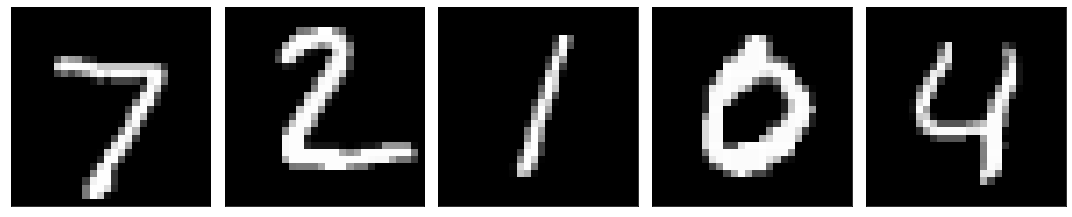

Shuffle 1


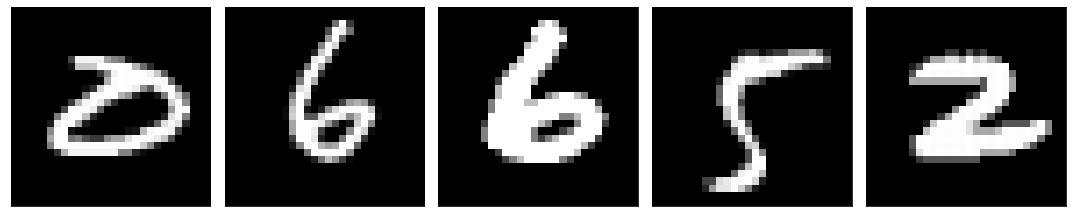

Shuffle 2


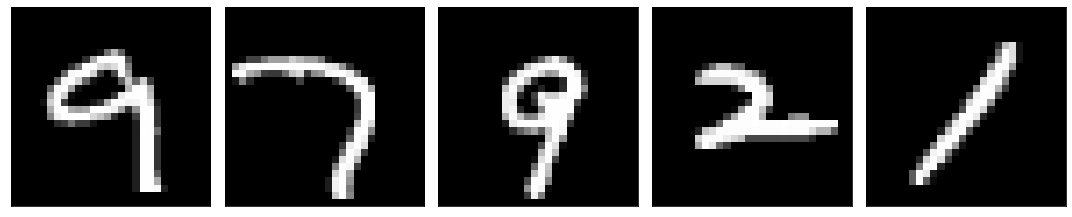

Shuffle 3


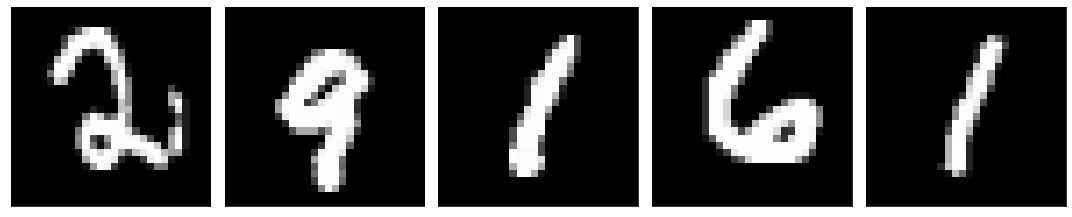

In [38]:
# Prepare MNIST Data
(train_data, train_label), (test_data, test_label) = datasets.mnist.load_data()
# Add new deminsion for TF2
train_data  = train_data[...,tf.newaxis] 
test_data   = test_data[...,tf.newaxis] 
train_label = train_label[...,tf.newaxis] 
test_label  = test_label[...,tf.newaxis] 

# Convert to float32
test_data = np.array(test_data,np.float32)

# Predict 5 images from test set
n_images = 5
test_images = test_data[:n_images]
# Display image and model prediction
print("Normal")
plt.figure(figsize=(15,15))
for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(test_images[i], [28,28]), cmap='gray')
plt.tight_layout()
plt.show()


## Shuffle data
np.random.shuffle(test_data)
n_images = 5
test_images = test_data[:n_images]

# Display image and model prediction
print("Shuffle 1")
plt.figure(figsize=(15,15))
for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(test_images[i], [28,28]), cmap='gray')
plt.tight_layout()
plt.show()


## Shuffle data
np.random.shuffle(test_data)
n_images = 5
test_images = test_data[:n_images]

# Display image and model prediction
print("Shuffle 2")
plt.figure(figsize=(15,15))
for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(test_images[i], [28,28]), cmap='gray')
plt.tight_layout()
plt.show()

## Shuffle data
np.random.shuffle(test_data)
n_images = 5
test_images = test_data[:n_images]

# Display image and model prediction
print("Shuffle 3")
plt.figure(figsize=(15,15))
for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(test_images[i], [28,28]), cmap='gray')
plt.tight_layout()
plt.show()

## Make Predicitions

Normal


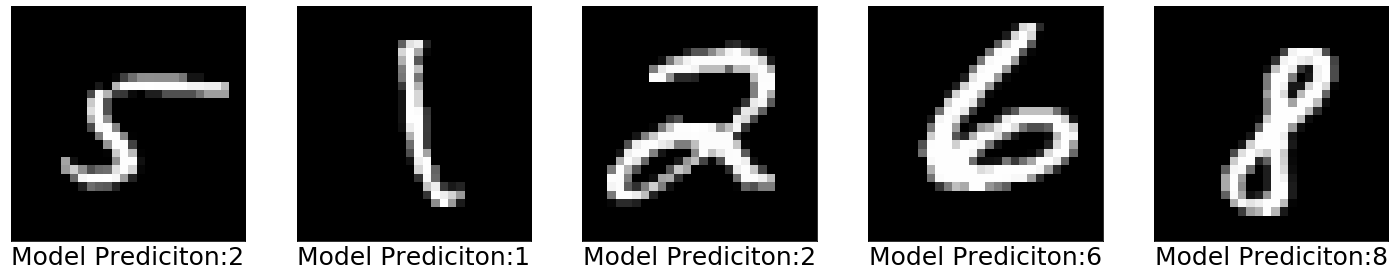

Shuffle 1


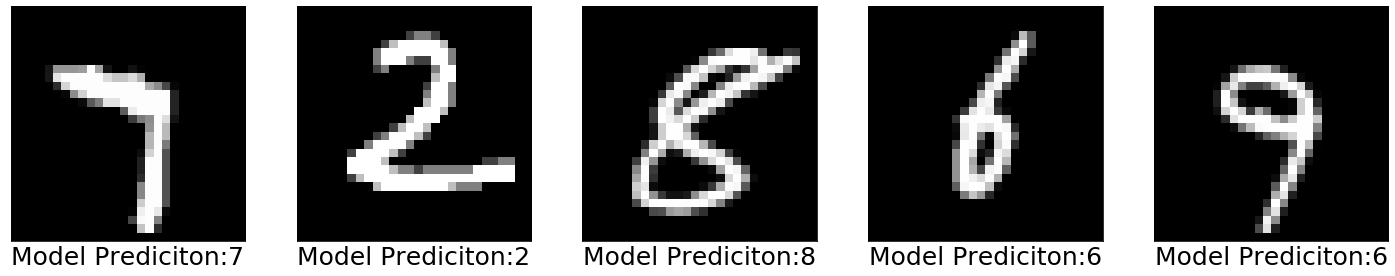

Shuffle 2


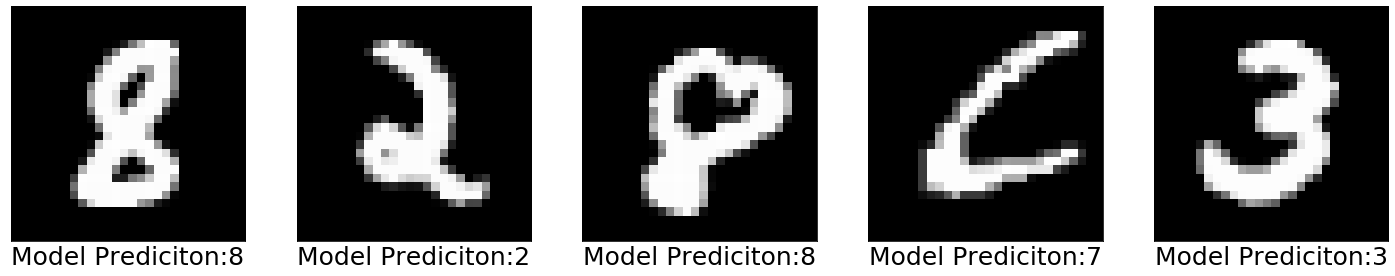

Shuffle 3


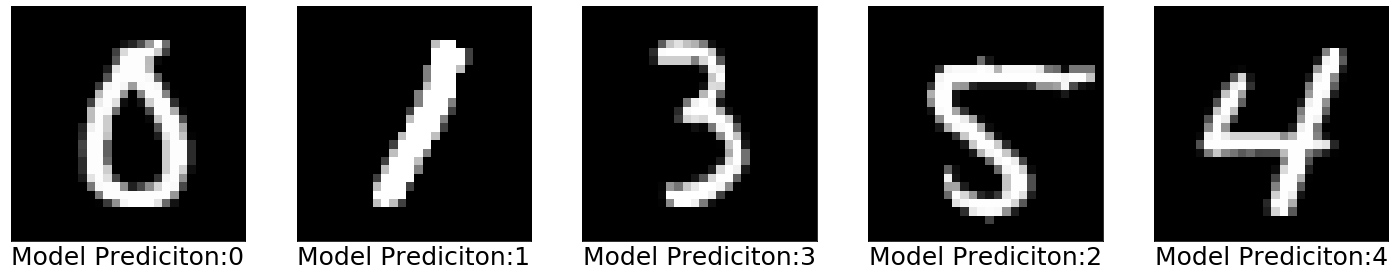

In [40]:
# Predict 5 images from test set
n_images = 5
test_images = test_data[:n_images]
predictions = model(test_images)

# Display image and model prediction
print("Normal")
plt.figure(figsize=(20,20))
for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(test_images[i], [28,28]), cmap='gray')
    plt.xlabel("Model Prediciton:%i" % np.argmax(predictions.numpy()[i]),fontsize=25)
plt.tight_layout()
plt.show()

## Shuffle data
np.random.shuffle(test_data)
n_images = 5
test_images = test_data[:n_images]
predictions = model(test_images)
# Display image and model prediction
print("Shuffle 1")
plt.figure(figsize=(20,20))
for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(test_images[i], [28,28]), cmap='gray')
    plt.xlabel("Model Prediciton:%i" % np.argmax(predictions.numpy()[i]),fontsize=25)

plt.tight_layout()
plt.show()

## Shuffle data
np.random.shuffle(test_data)
n_images = 5
test_images = test_data[:n_images]
predictions = model(test_images)
# Display image and model prediction
print("Shuffle 2")
plt.figure(figsize=(20,20))
for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(test_images[i], [28,28]), cmap='gray')
    plt.xlabel("Model Prediciton:%i" % np.argmax(predictions.numpy()[i]),fontsize=25)

plt.tight_layout()
plt.show()

## Shuffle data
np.random.shuffle(test_data)
n_images = 5
test_images = test_data[:n_images]
predictions = model(test_images)
# Display image and model prediction
print("Shuffle 3")
plt.figure(figsize=(20,20))
for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(test_images[i], [28,28]), cmap='gray')
    plt.xlabel("Model Prediciton:%i" % np.argmax(predictions.numpy()[i]),fontsize=25)

plt.tight_layout()
plt.show()